In [1]:
import random
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import copy
from torch_geometric.utils import degree
import torch
from torch import nn, optim, Tensor
from torch_sparse import SparseTensor, matmul

from torch_geometric.data import download_url, extract_zip
from torch_geometric.utils import structured_negative_sampling
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.typing import Adj
from torch_geometric.nn.conv import MessagePassing

from scipy import sparse

In [2]:
url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
extract_zip(download_url(url, '.'), '.')

movie_path = 'ml-latest-small/movies.csv'
rating_path = 'ml-latest-small/ratings.csv'
user_path = 'ml-latest-small/users.csv'

Using existing file ml-latest-small.zip
Extracting ./ml-latest-small.zip


In [3]:
rating_df = pd.read_csv(rating_path)

print(rating_df.head())

print(len(rating_df['movieId'].unique()))
print(len(rating_df['userId'].unique()))

rating_df.describe()

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
9724
610


,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [4]:
# perform encoding preprocessing to ensure that user_id nad item_id are both
# in the range of [0, unique_count] so it won't cause out of bound issue when indexing embeddings

lbl_user = preprocessing.LabelEncoder()
lbl_movie = preprocessing.LabelEncoder()

rating_df.userId = lbl_user.fit_transform(rating_df.userId.values)
rating_df.movieId = lbl_movie.fit_transform(rating_df.movieId.values)

print(rating_df.userId.max())
print(rating_df.movieId.max())

609
9723


<Axes: xlabel='rating'>

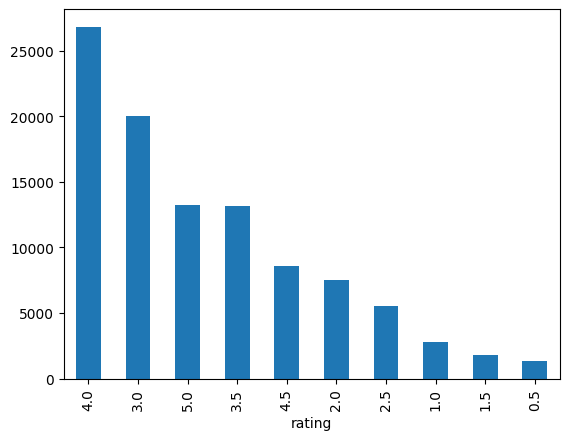

In [5]:
rating_df.rating.value_counts().plot(kind='bar')

In [6]:
# load edges between users and movies
def load_edge_csv(df,
                  src_index_col,
                  dst_index_col,
                  link_index_col=None,
                  rating_treshold=3):
    edge_index = None
    src = [user_id for user_id in df['userId']]
    dst = [movie_id for movie_id in df['movieId']]

    edge_attr = torch.from_numpy(df[link_index_col].values).view(-1, 1).to(torch.long) >= rating_treshold

    edge_index = [[], []]
    for i in range(edge_attr.shape[0]):
        if edge_attr[i]:
            edge_index[0].append(src[i])
            edge_index[1].append(dst[i])
    return edge_index

In [7]:
edge_index = load_edge_csv(rating_df, 'userId', 'movieId', 'rating', rating_treshold=3.5)

In [8]:
print(f"{len(edge_index)} x {len(edge_index[0])}")

2 x 48580


In [9]:
edge_index = torch.LongTensor(edge_index)
print(edge_index)
print(edge_index.size())

tensor([[   0,    0,    0,  ...,  609,  609,  609],
        [   0,    2,    5,  ..., 9443, 9444, 9445]])
torch.Size([2, 48580])


In [10]:
# before we apply rating treshhold
num_users = len(rating_df['userId'].unique())
num_movies = len(rating_df['movieId'].unique())

In [11]:
num_interactions = edge_index.shape[1]

# split the edges of the graphs using a 80/10/10 ratio
all_indices = [i for i in range(num_interactions)]

train_indices, test_indices = train_test_split(all_indices, test_size=0.2, random_state=1)

val_indices, test_indices = train_test_split(test_indices, test_size=0.5, random_state=1)

train_edge_index = edge_index[:, train_indices]
val_edge_index = edge_index[:, val_indices]
test_edge_index = edge_index[:, test_indices]

In [12]:
print(f"num_users: {num_users}, num_movies: {num_movies}, num_interactions: {num_interactions}")
print(f"train_edge_index: {train_edge_index.size()}")
print(f"num_users + num_movies: {num_users + num_movies}")
print(torch.unique(train_edge_index[0]).size())
print(torch.unique(train_edge_index[1]).size())

num_users: 610, num_movies: 9724, num_interactions: 48580
train_edge_index: torch.Size([2, 38864])
num_users + num_movies: 10334
torch.Size([609])
torch.Size([5676])


In [13]:
def convert_r_mat_edge_index_to_adj_mat_edge_index(input_edge_index):
    R = torch.zeros((num_users, num_movies))
    
# convert sparse coo format to dense format to get R matrix
    for i in range(len(input_edge_index[0])):
        row_idx = input_edge_index[0][i]
        col_idx = input_edge_index[1][i]
        R[row_idx][col_idx] = 1


    R_transpose = torch.transpose(R, 0, 1)
    adj_mat = torch.zeros((num_users + num_movies, num_users + num_movies))
    adj_mat[:num_users, num_users:] = R.clone()
    adj_mat[num_users:, :num_users] = R_transpose.clone()
    adj_mat_coo = adj_mat.to_sparse_coo()
    adj_mat_coo = adj_mat_coo.indices()
    return adj_mat_coo

In [14]:
def convert_adj_mat_edge_index_to_r_mat_edge_index(input_edge_index):
    sparse_input_edge_index = SparseTensor(row=input_edge_index[0],
                                            col=input_edge_index[1],
                                            sparse_sizes=(num_users + num_movies, num_users + num_movies))
    adj_mat = sparse_input_edge_index.to_dense()
    interact_mat = adj_mat[:num_users, num_users:]
    r_mat_edge_index = interact_mat.to_sparse_coo().indices()
    return r_mat_edge_index

In [15]:
# convert from r_mat edge index to adj matirices edge index
# so we can feed it to the GCN model
train_edge_index = convert_r_mat_edge_index_to_adj_mat_edge_index(train_edge_index)
val_edge_index = convert_r_mat_edge_index_to_adj_mat_edge_index(val_edge_index)
test_edge_index = convert_r_mat_edge_index_to_adj_mat_edge_index(test_edge_index)

In [16]:
print(train_edge_index)
print(train_edge_index.size())
print(val_edge_index)
print(val_edge_index.size())
print(test_edge_index)
print(test_edge_index.size())

tensor([[    0,     0,     0,  ..., 10326, 10327, 10333],
        [  610,   612,   653,  ...,   183,   183,   330]])
torch.Size([2, 77728])
tensor([[    0,     0,     0,  ..., 10226, 10236, 10240],
        [  615,   794,  2010,  ...,   317,   204,   413]])
torch.Size([2, 9716])
tensor([[    0,     0,     0,  ..., 10301, 10302, 10329],
        [  811,  1086,  1095,  ...,   585,   585,   183]])
torch.Size([2, 9716])


In [17]:
def sample_mini_batch(batch_size, edge_index):
    edges = structured_negative_sampling(edge_index)
    edges = torch.stack(edges, dim=0)
    indices = random.choices([i for i in range(edges.size(0))], k=batch_size)
    batch = edges[:, indices]
    user_indices, pos_item_indices, neg_item_indices = batch[0], batch[1], batch[2]
    return user_indices, pos_item_indices, neg_item_indices

In [18]:
class LightGCN(MessagePassing):
    def __init__(self, num_users,
                 num_items,
                 embedding_dim=64,
                 K=3,
                 add_self_loops=False):
        super().__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim
        self.K = K
        self.add_self_loops = add_self_loops

        self.user_emb = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.embedding_dim)
        self.item_emb = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.embedding_dim)

        nn.init.normal_(self.user_emb.weight, std=0.01)
        nn.init.normal_(self.item_emb.weight, std=0.01)

    def forward(self, edge_index: Tensor):
        edge_index_norm = gcn_norm(edge_index= edge_index, add_self_loops=self.add_self_loops)
        emb_0 = torch.cat([self.user_emb.weight, self.item_emb.weight])
        embs = [emb_0]
        emb_k = emb_0
        for k in range(self.K):
            emb_k = self.propagate(edge_index_norm[0], x=emb_k, norm=edge_index_norm[1])
            embs.append(emb_k)
        embs = torch.stack(embs, dim=1)
        emb_final = torch.mean(embs, dim=1)
        user_emb_final, items_emb_final = torch.split(emb_final, [self.num_users, self.num_items])
        return user_emb_final, self.user_emb.weight, items_emb_final, self.item_emb.weight
    def message(self, x_j: Tensor, norm: Tensor):
        return norm.view(-1, 1) * x_j



In [19]:
layers = 3
model = LightGCN(num_users=num_users, num_items=num_movies, embedding_dim=64, K=layers)

In [20]:
def bpr_loss(users_emb_final,
             users_emb_0,
             pos_items_emb_final,
             pos_items_emb_0,
             neg_items_emb_final,
             neg_items_emb_0,
             lambda_val):
    reg_loss = lambda_val * (users_emb_0.norm(2).pow(2) + 
                             pos_items_emb_0.norm(2).pow(2) + 
                             neg_items_emb_0.norm(2).pow(2))
    pos_scores = torch.mul(users_emb_final, pos_items_emb_final)
    pos_scores = torch.sum(pos_scores, dim=1)
    neg_scores = torch.mul(users_emb_final, neg_items_emb_final)
    neg_scores = torch.sum(neg_scores, dim=1)

    bpr_loss = -torch.log(torch.sigmoid(pos_scores - neg_scores)).sum()
    loss = bpr_loss + reg_loss
    return loss



In [21]:
def get_user_positive_items(edge_index):
    user_pos_items = {}
    for i in range(edge_index.shape[1]):
        user_id = edge_index[0][i].item()
        item_id = edge_index[1][i].item()
        if user_id not in user_pos_items:
            user_pos_items[user_id] = []
        user_pos_items[user_id].append(item_id)
    return user_pos_items

In [22]:
def RecallPrecision_ATK(groungTruth, r, k):
    num_correct_pred = torch.sum(r, dim=-1)
    user_num_liked = torch.Tensor([len(groungTruth[i]) for i in range(len(groungTruth))])
    recall = torch.mean(num_correct_pred / user_num_liked)
    precision = torch.mean(num_correct_pred / k)
    return recall.item(), precision.item()

In [23]:
# computes NDCG@K
def NDCGatK_r(groungTruth, r, k):
    assert len(r) == len(groungTruth)
    test_matrix = torch.zeros((len(r),k))
    for i, items in enumerate(groungTruth):
        length = min(len(items), k)
        test_matrix[i,:length] = 1
    max_r = test_matrix
    idcg = torch.sum(max_r * 1 / torch.log2(torch.arange(2, k + 2)), axis=1)
    dcg = r * (1 / torch.log2(torch.arange(2, k + 2)))
    dcg = torch.sum(dcg, axis=1)
    idcg[idcg == 0] = 1
    ndcg = dcg / idcg
    ndcg[torch.isnan(ndcg)] = 0
    return torch.mean(ndcg).item()

In [24]:
# wraper function to getevaluation metrics
def get_metrics(model,
                input_edge_index,
                input_exclude_edge_indices,
                k):
    user_embedding = model.user_emb.weight
    item_embedding = model.item_emb.weight

    edge_index = convert_adj_mat_edge_index_to_r_mat_edge_index(input_edge_index)

    exclude_edge_indices = [convert_adj_mat_edge_index_to_r_mat_edge_index(exclude_edge_index) \
                            for exclude_edge_index in input_exclude_edge_indices]
    
    r_mat_rating = torch.matmul(user_embedding, item_embedding.T)
    rating = r_mat_rating 

    for exclude_edge_index in exclude_edge_indices:
        user_pos_items = get_user_positive_items(exclude_edge_index)
        exclude_users = []
        exclude_items = []
        for user, items in user_pos_items.items():
            exclude_users.extend([user] * len(items))
            exclude_items.extend(items)

        rating[exclude_users, exclude_items] = -(1 << 10)
    _, top_k_items = torch.topk(rating, k=k)
    users = edge_index[0].unique()
    test_user_pos_items = get_user_positive_items(edge_index)
    test_user_pos_items_list = [test_user_pos_items[user.item()] for user in users]
    r = []
    for user in users:
        user_true_relevant_item = test_user_pos_items[user.item()]
        label = list(map(lambda x: x in user_true_relevant_item, top_k_items[user]))
        r.append

    r = torch.Tensor(np.array(r).astype('float'))
    recall, precision = RecallPrecision_ATK(test_user_pos_items_list, r, k)
    ndcg = NDCGatK_r(test_user_pos_items_list, r, k)

    return recall, precision, ndcg









In [25]:
# wraper function for evaluation model
def evaluation(model,
               edge_index,
               exclude_edge_indices,
               k,
               lambda_val):
    user_emb_final, user_emb_0, items_emb_final, items_emb_0 = model.forward(edge_index)
    r_mat_edge_index = convert_adj_mat_edge_index_to_r_mat_edge_index(edge_index)
    edges = structured_negative_sampling(r_mat_edge_index, contains_neg_self_loops=False)
    user_indices, pos_item_indices, neg_item_indices = edges[0], edges[1], edges[2]
    users_emb_final, users_emb_0 = user_emb_final[user_indices], user_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[neg_item_indices], items_emb_0[neg_item_indices]
    loss = bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, lambda_val)
    recall, precision, ndcg = get_metrics(model, edge_index, exclude_edge_indices, k)
    return loss, recall, precision, ndcg



In [26]:
ITERATIONS = 10
EPOCHS = 10

BATCH_SIZE = 1024
LR = 1e-3
ITERS_PER_EVAL = 200
ITERS_PER_LR_DECAY = 200
LAMBDA = 1e-6

In [27]:
# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

model = model.to(device)
model.train()

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=ITERS_PER_LR_DECAY, gamma=0.5)

edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
val_edge_index = val_edge_index.to(device)




Device: cpu


In [28]:
def get_embs_for_bpr(model, input_edge_index):
    user_emb_final, user_emb_0, items_emb_final, items_emb_0 = model.forward(input_edge_index)
    edge_index_to_use = convert_adj_mat_edge_index_to_r_mat_edge_index(input_edge_index)
    user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(BATCH_SIZE, edge_index_to_use)
    user_indices, pos_item_indices, neg_item_indices = user_indices.to(device), pos_item_indices.to(device), neg_item_indices.to(device)

    users_emb_final, users_emb_0 = user_emb_final[user_indices], user_emb_0[user_indices]
    pos_item_emb_final, pos_item_emb_0 = items_emb_final[pos_item_indices], items_emb_0[pos_item_indices]
    neg_item_emb_final, neg_item_emb_0 = items_emb_final[neg_item_indices], items_emb_0[neg_item_indices]

    return users_emb_final, users_emb_0, pos_item_emb_final, pos_item_emb_0, neg_item_emb_final, neg_item_emb_0

In [29]:
# %pip install --upgrade jupyter ipywidgets

In [30]:
# training loop
train_losses = []
val_losses = []
val_recall_at_ks = []

for iter in tqdm(range(ITERATIONS)):
    # forward pass
    users_emb_final, users_emb_0, pos_item_emb_final, pos_item_emb_0, neg_item_emb_final, neg_item_emb_0 = get_embs_for_bpr(model, train_edge_index)

    # loss computation
    train_loss = bpr_loss(users_emb_final, users_emb_0, pos_item_emb_final, pos_item_emb_0, neg_item_emb_final, neg_item_emb_0, LAMBDA)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # validation
    if iter % ITERS_PER_EVAL == 0:
        model.eval()


        with torch.no_grad():
            val_loss, val_recall, val_precision, val_ndcg = evaluation(model, val_edge_index, [train_edge_index], 10, LAMBDA)
            val_losses.append(val_loss)
            val_recall_at_ks.append(val_recall)
            print(f"Validation loss: {val_loss}, Recall@10: {val_recall}, Precision@10: {val_precision}, NDCG@10: {val_ndcg}")

            train_losses.append(train_loss.item())
            val_losses.append(val_loss)
            val_recall_at_ks.append(round(val_recall, 5))
        model.train()
    if iter % ITERS_PER_LR_DECAY == 0 and iter > 0:
        scheduler.step()


  0%|          | 0/10 [00:00<?, ?it/s]

AssertionError: 